<a href="https://colab.research.google.com/github/sharifovrus/XGBoost-Model-for-Miami-Metropolitan-Area-Housing-Prices-Dataset/blob/main/XGBoost_Model_for_Miami_Metropolitan_Area_Housing_Prices_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import basic libraries and load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('Miami–Fort Lauderdale–West Palm Beach Area from Jupiter to Homestead.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 27 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   SALE TYPE                                                                                    350 non-null    object 
 1   SOLD DATE                                                                                    0 non-null      float64
 2   PROPERTY TYPE                                                                                350 non-null    object 
 3   ADDRESS                                                                                      336 non-null    object 
 4   CITY                                                                                         349 non-null    object 
 5   STATE OR PROVINCE                   

In [ ]:
#Remove outliers
z_scores = np.abs((data['PRICE'] - data['PRICE'].mean()) / data['PRICE'].std())
# Define a z-score threshold
z_score_threshold = 1.5
# Remove rows with house prices with z-scores above the threshold
data = data[z_scores <= z_score_threshold]

print(data.shape[0])


342


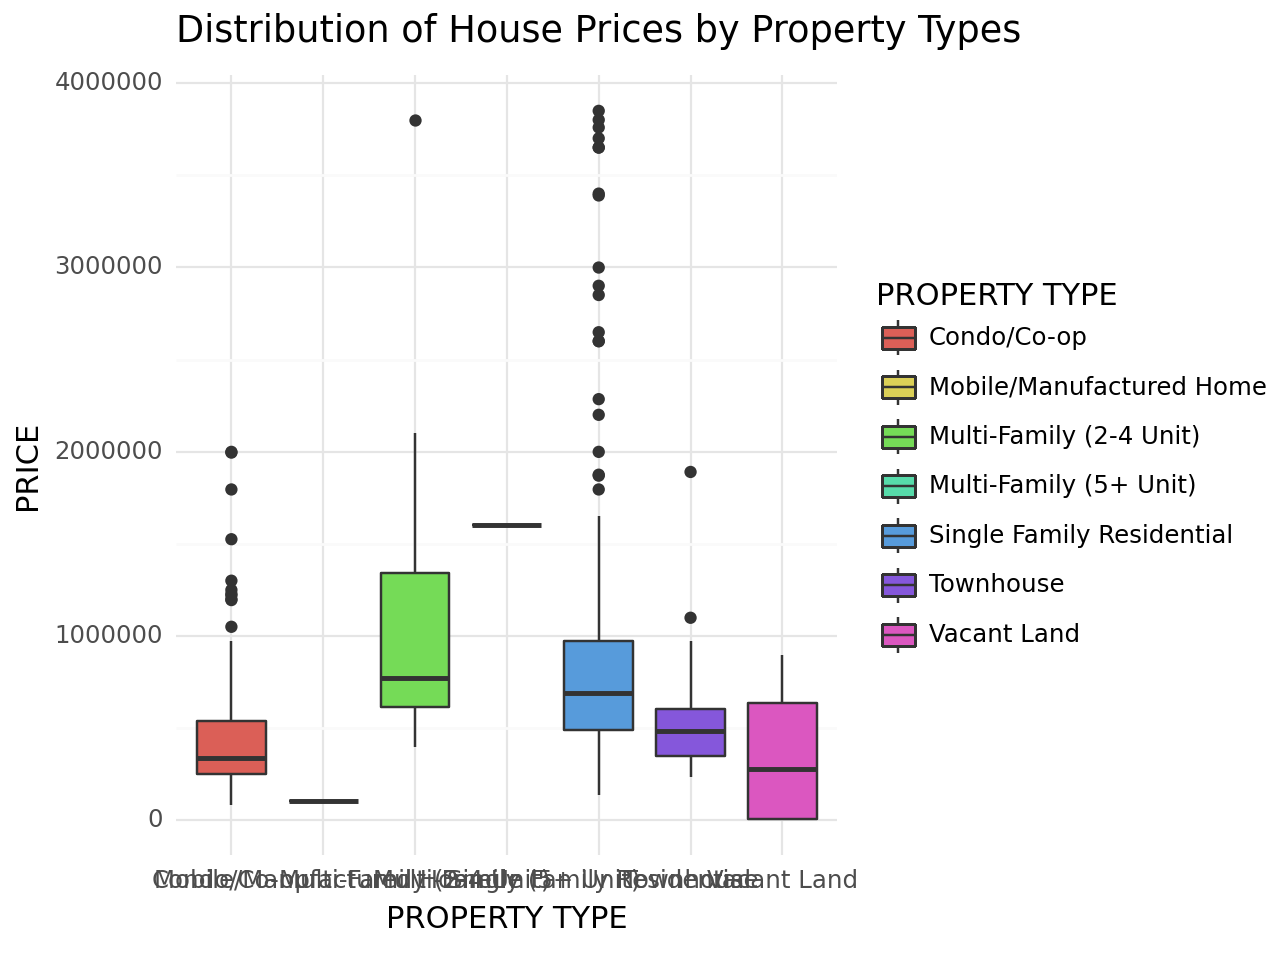

In [ ]:
from plotnine import ggplot, aes, geom_boxplot, theme_minimal, labs

plot = (
    ggplot(data, aes(x='PROPERTY TYPE', y='PRICE', fill='PROPERTY TYPE')) +
    geom_boxplot() +
    theme_minimal() +
    labs(title='Distribution of House Prices by Property Types',
         x='PROPERTY TYPE',
         y='PRICE')
)

print(plot)

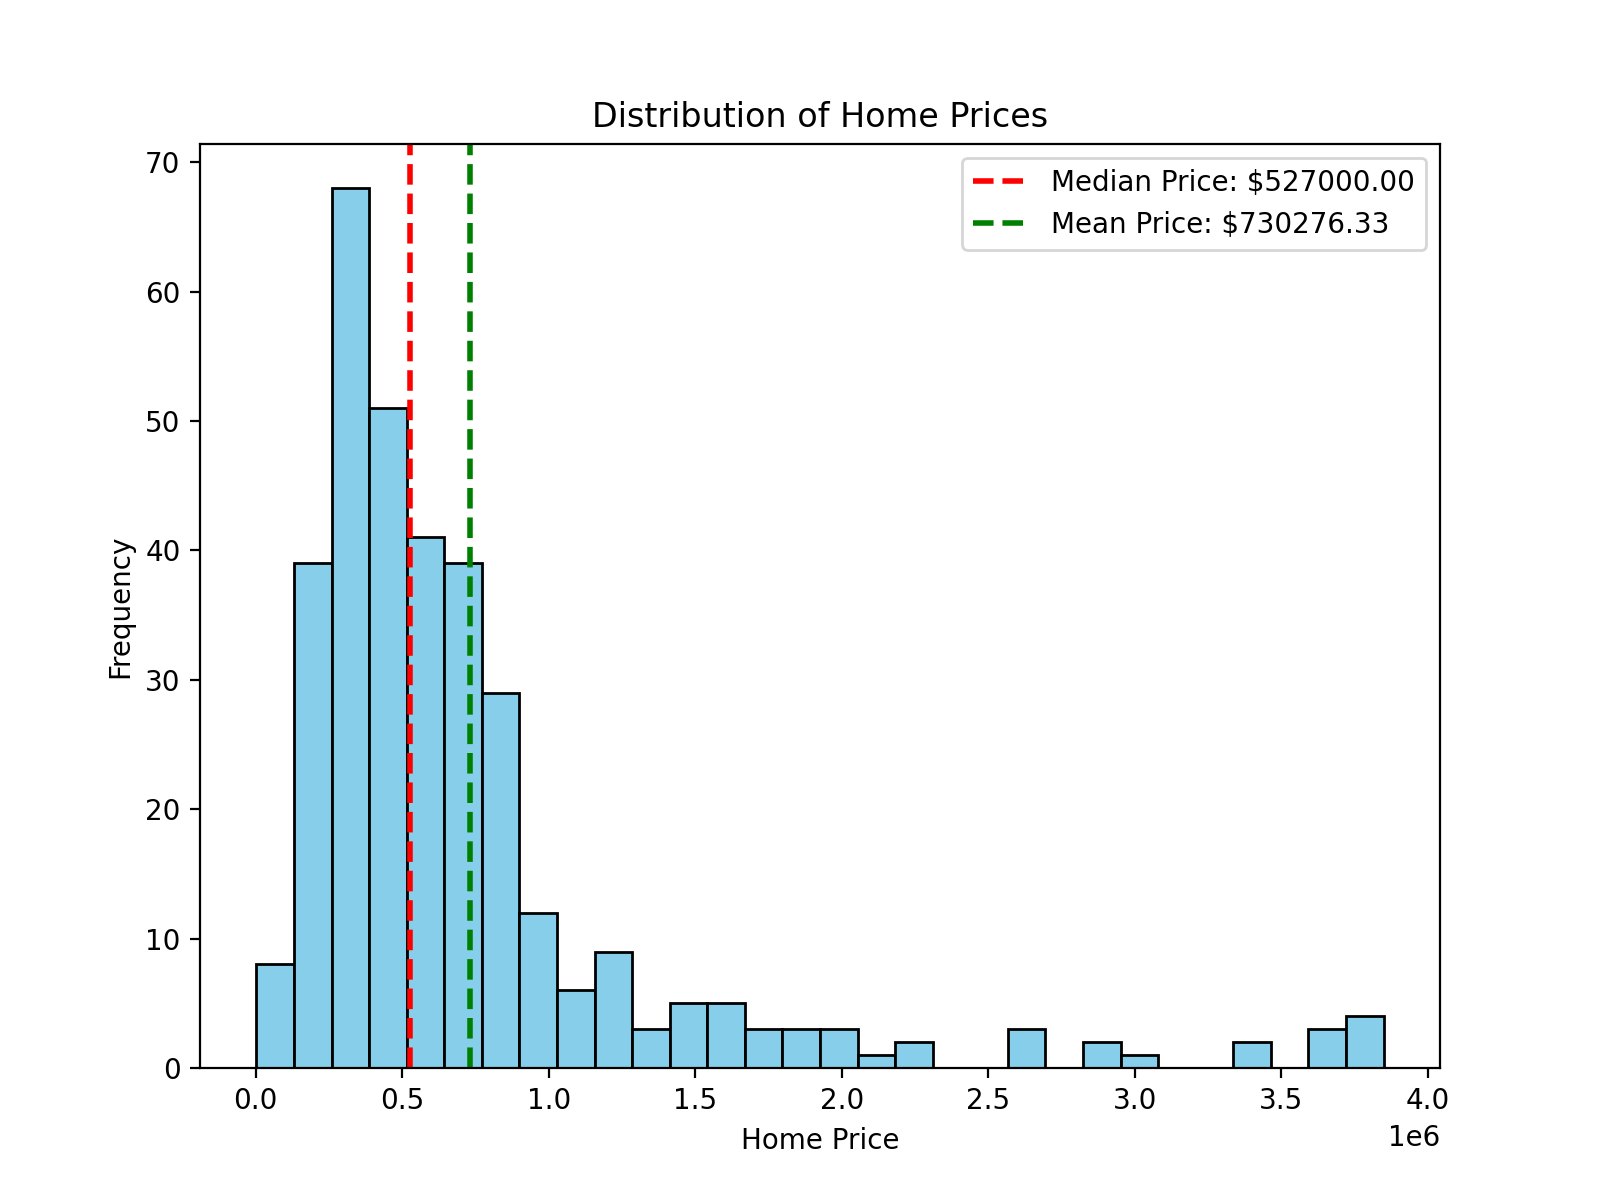

In [ ]:
median_price = data['PRICE'].median()

mean_price = data['PRICE'].mean()

plt.figure(figsize=(8, 6))
plt.hist(data['PRICE'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(median_price, color='red', linestyle='dashed', linewidth=2, label=f'Median Price: ${median_price:.2f}')
plt.axvline(mean_price, color='green', linestyle='dashed', linewidth=2, label=f'Mean Price: ${mean_price:.2f}')
plt.xlabel('Home Price')
plt.ylabel('Frequency')
plt.title('Distribution of Home Prices')
plt.legend()
plt.show()



In [ ]:
data.drop(['SALE TYPE', 'SOLD DATE', 'PROPERTY TYPE', 'ADDRESS', 'CITY', 'STATE OR PROVINCE', 'LOCATION', 'STATUS', 'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME', 'URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)', 'SOURCE', 'MLS#', 'FAVORITE', 'INTERESTED'], axis=1, inplace=True)
data.head()

,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE
0,33309,299900,2.0,1.5,978.0,NaN,1984.0,3,307.0,450.0,26.168078,-80.179417
1,33027,650000,4.0,2.5,1823.0,4009.0,2002.0,4,357.0,150.0,25.958731,-80.316240
2,33467,479000,2.0,2.0,1598.0,7686.0,1986.0,4,300.0,179.0,26.601695,-80.183082
3,33141,515000,2.0,2.0,1030.0,NaN,1987.0,4,500.0,842.0,25.847672,-80.145868
4,33056,440000,3.0,1.5,1190.0,7500.0,1954.0,7,370.0,NaN,25.933967,-80.250711


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Separate features and target
X = data.drop('PRICE', axis=1)  # Exclude the target column
y = data['PRICE']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

final_model = XGBRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

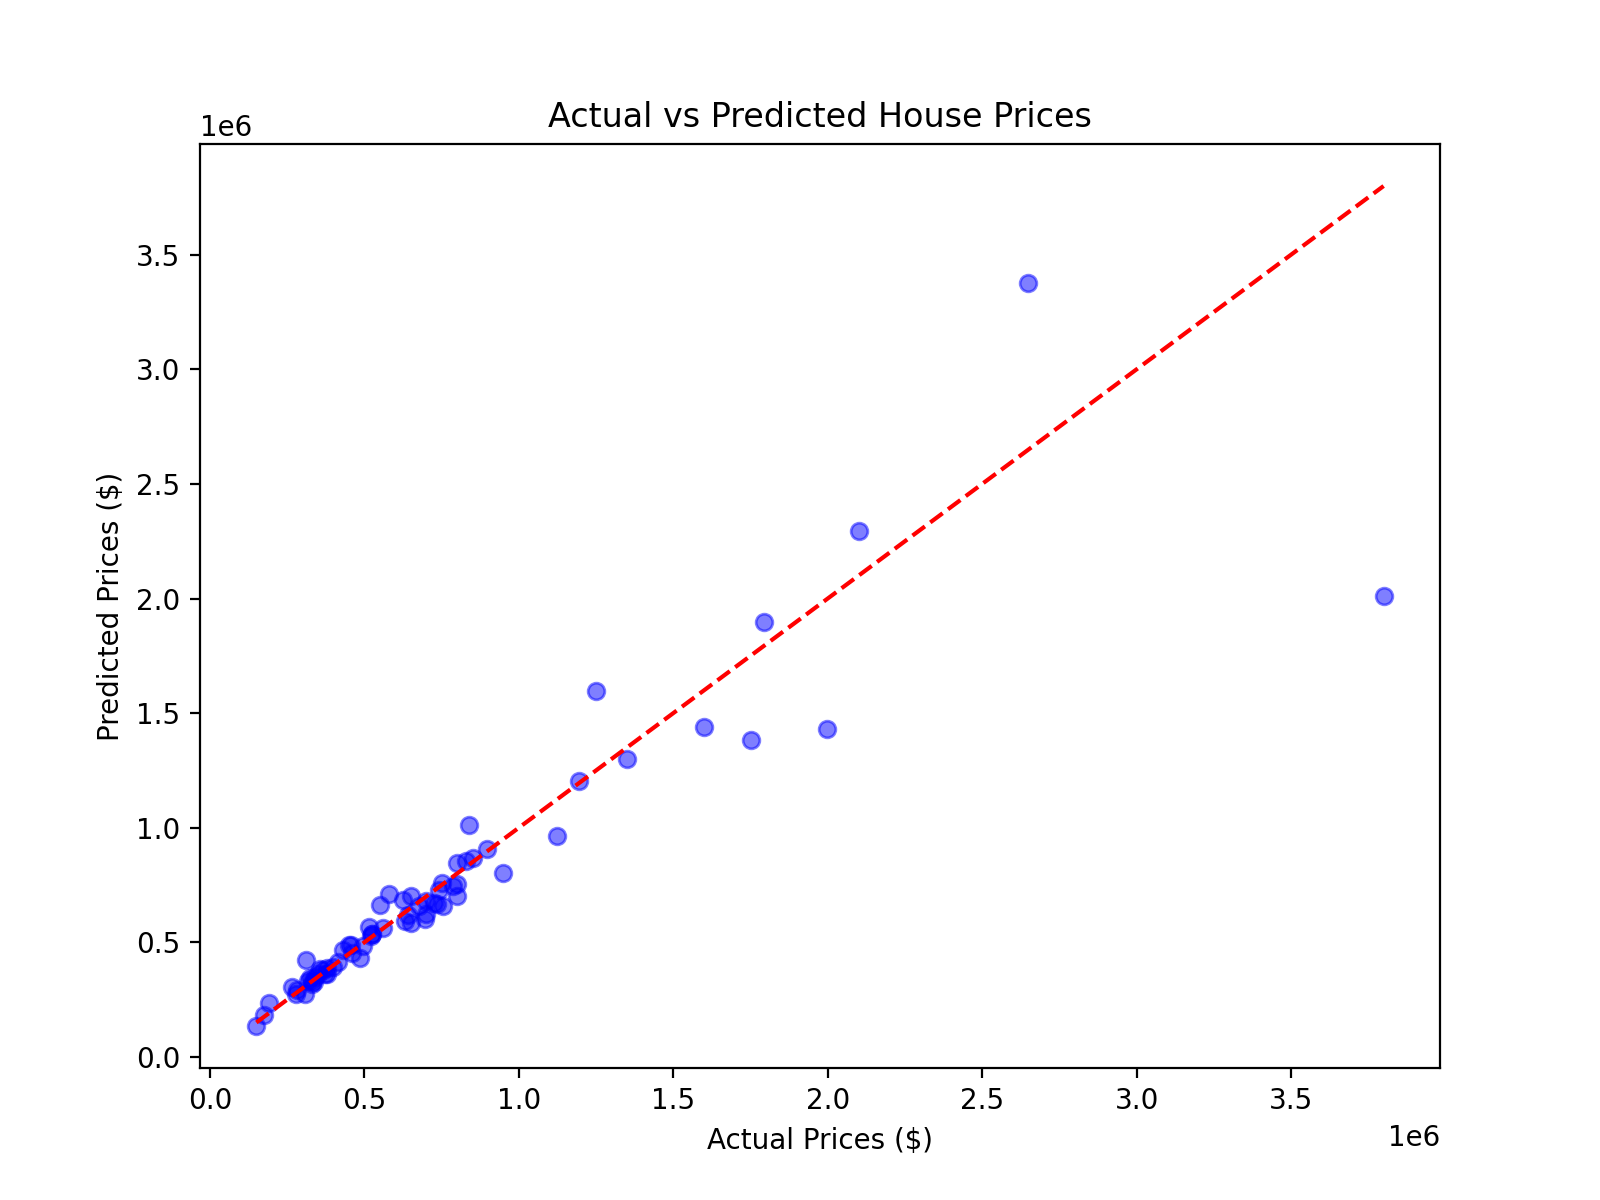

In [ ]:
y_pred = final_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('Actual Prices ($)')
plt.ylabel('Predicted Prices ($)')
plt.title('Actual vs Predicted House Prices')
plt.show()


In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 66557487971.22261


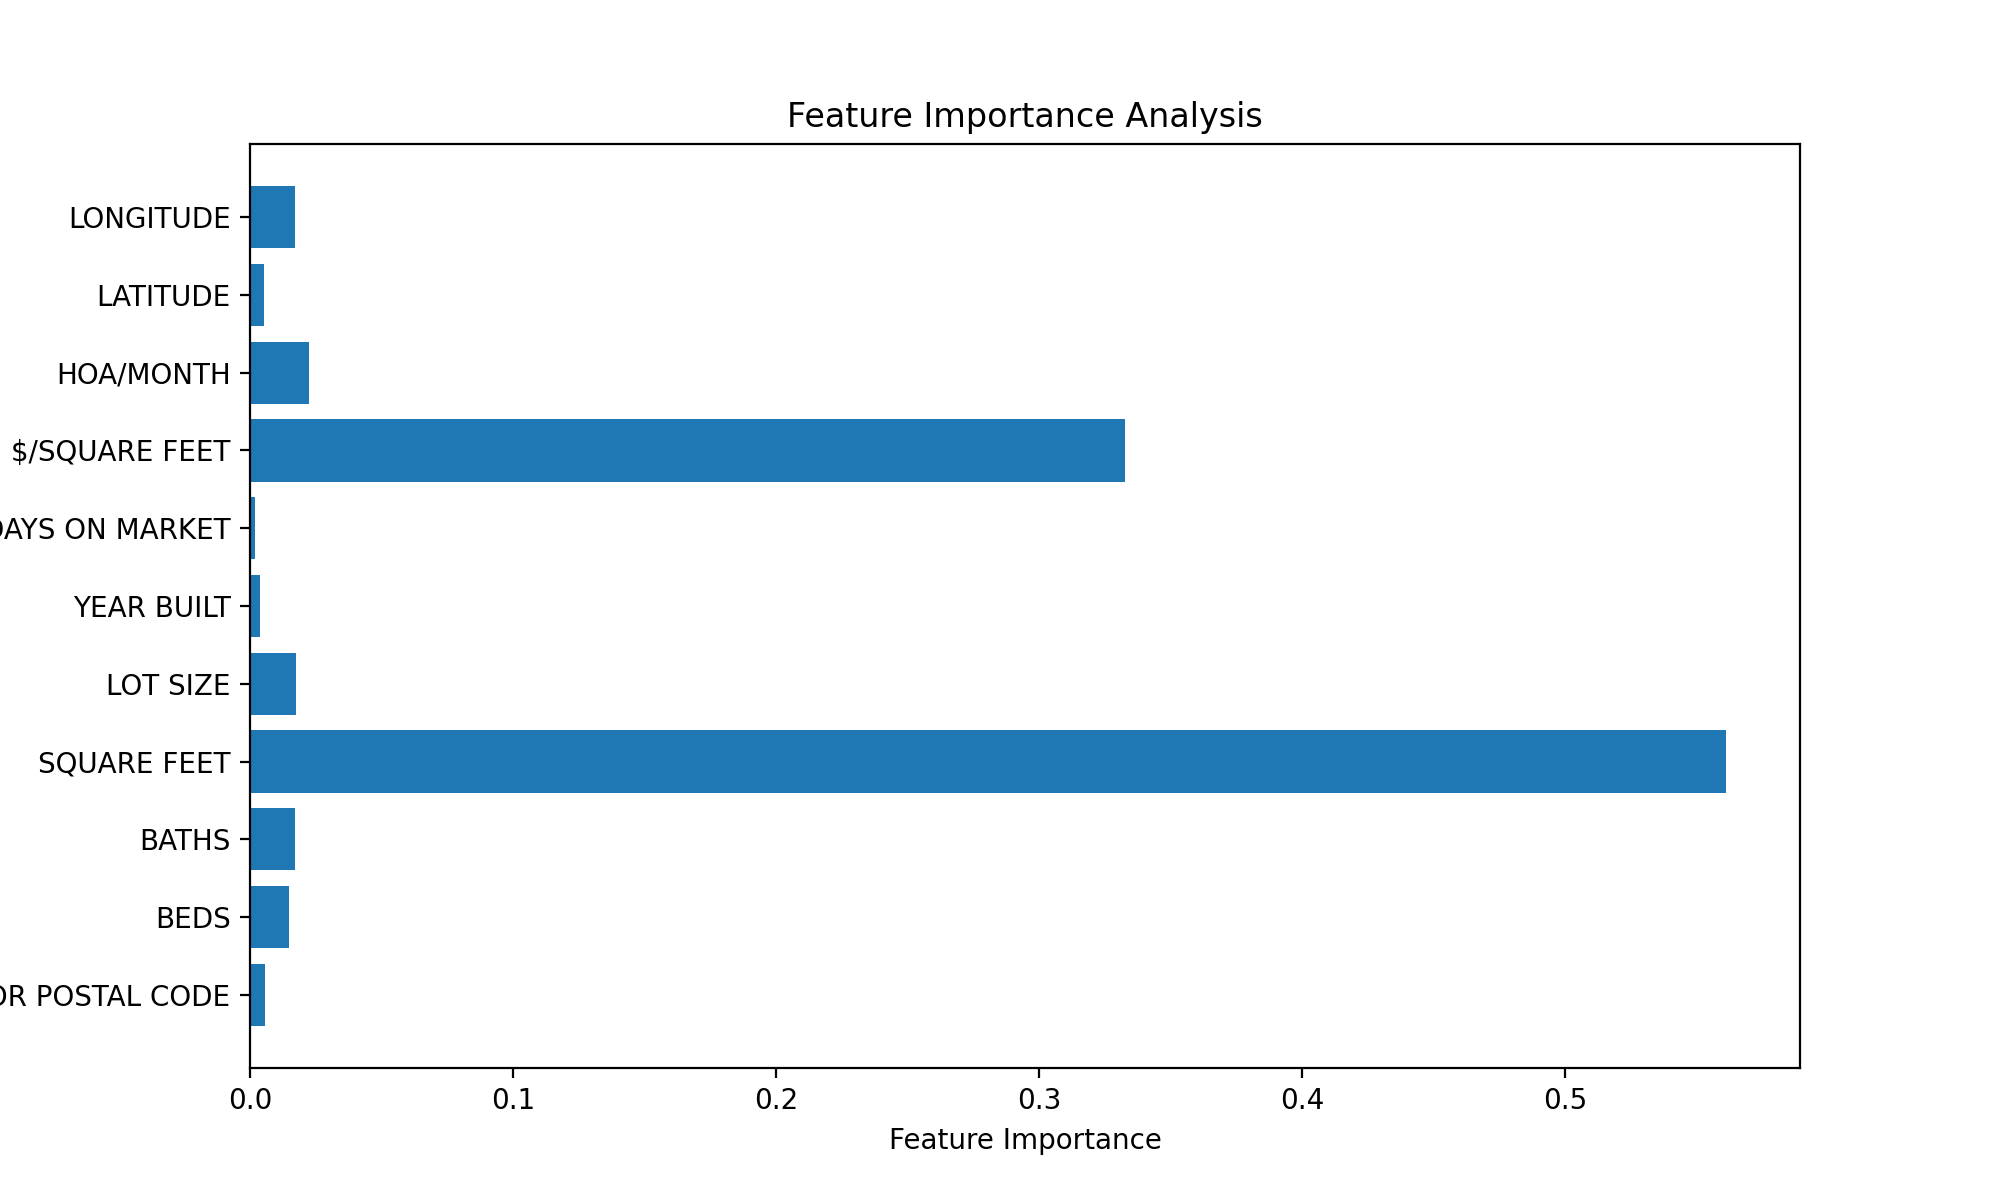

In [ ]:
feature_importances = final_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Analysis')
plt.show()